<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/c4_w3_simple_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.backend import clear_session
from tensorflow.random import set_seed
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, SimpleRNN, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import mean_absolute_error

tf.__version__

'2.4.0'

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
trend_series = trend(time, slope)
seasonality_series = seasonality(time, period=365, amplitude=amplitude)
noise_series = noise(time, noise_level, seed=42)
series = baseline + trend_series + seasonality_series + noise_series

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1])
    )
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
clear_session()
set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(
    x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size
)

In [7]:
model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    SimpleRNN(40, return_sequences=True),
    SimpleRNN(40),
    Dense(1),
    Lambda(lambda x: x * 100.0)
])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 30ms/step - loss: 194.6264 - mae: 195.1264
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 195.2580 - mae: 195.7580
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 192.3059 - mae: 192.8059
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 187.5114 - mae: 188.0114
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 185.2976 - mae: 185.7976
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 183.4114 - mae: 183.9114
Epoch 9/100
8/8 [==============================] - 0s 27ms/step - loss: 180.7796 - mae: 181.2796
Epoch 10/100
8/8 [==============================] - 0s 31ms/step - loss: 176.5626 - mae: 177.0626
Epoch 11/100
8/8 [===========

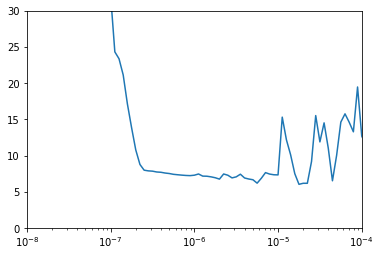

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30]);

In [9]:
clear_session()
set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(
    x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size
)

model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    SimpleRNN(40, return_sequences=True),
    SimpleRNN(40),
    Dense(1),
    Lambda(lambda x: x * 100.0)
])

optimizer = SGD(lr=1e-5, momentum=0.9)
model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 29ms/step - loss: 137.1878 - mae: 137.6871
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 32.3148 - mae: 32.8131
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 17.5521 - mae: 18.0466
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 15.4582 - mae: 15.9556
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 10.9417 - mae: 11.4338
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 9.2312 - mae: 9.7215
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 8.5810 - mae: 9.0656
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 6.5224 - mae: 7.0092
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 6.0997 - mae: 6.5834
Epoch 10/100
8/8 [==============================] - 0s 27ms/step - loss: 5.5826 - mae: 6.0613
Epoch 11/100
8/8 [==============================] - 0s 28

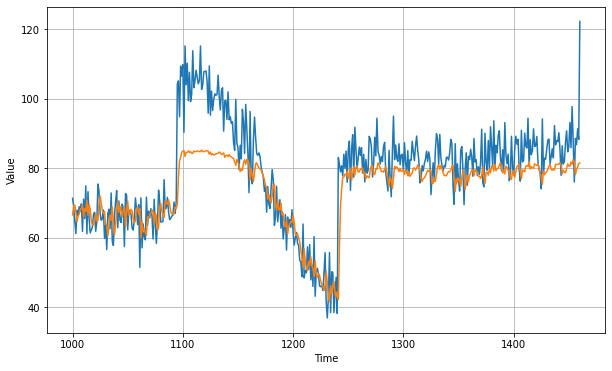

In [10]:
forecast = []
for time in range(len(series) - window_size):
    pred = model.predict(series[time:time+window_size][np.newaxis])
    forecast.append(pred)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


In [11]:
mean_absolute_error(x_valid, results).numpy()

6.8839793

<Figure size 432x288 with 0 Axes>

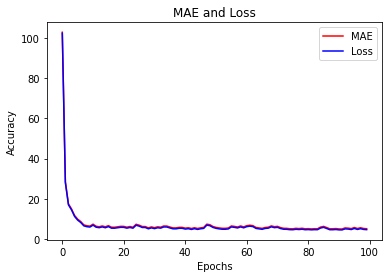

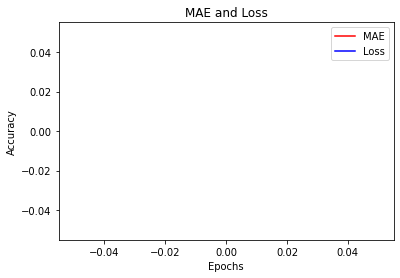

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()